# Diffusion Models

In [1]:
import numpy
import torch
import torchvision
import matplotlib.pyplot as plt

# HuggingFace
import diffusers
import datasets

%matplotlib inline

## Setting Device

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: mps


## Part 1: A Minimal Example

Showing the standard Diffuser Pipeline (using a pre-trained model).

In [3]:
image_pipe = diffusers.DDPMPipeline.from_pretrained("google/ddpm-celebahq-256", use_safetensors=False)
image_pipe.to(device);

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/tets/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/tets/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 39.8 s, sys: 5.43 s, total: 45.2 s
Wall time: 1min 33s


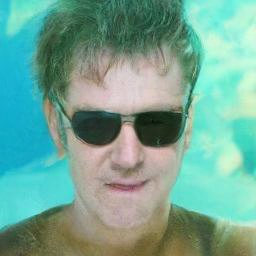

In [4]:
%%time
# run pipeline in inference (sample random noise and denoise)
face_image = image_pipe().images[0]
face_image

## Part 2: Understanding How It Works

Showing how we denoise pictures, step after step.

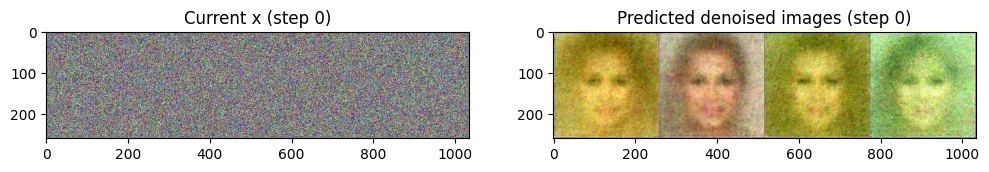

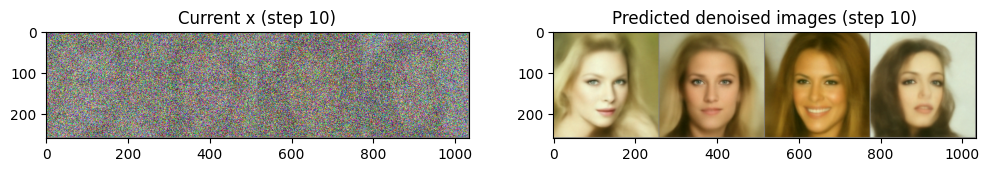

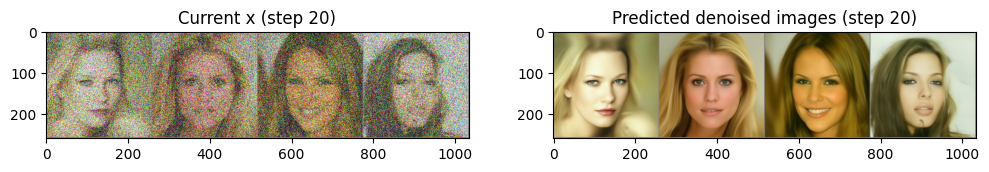

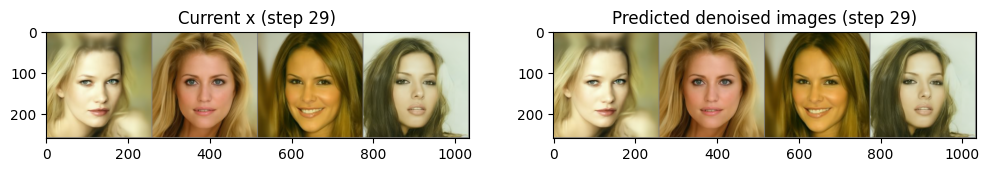

CPU times: user 7.48 s, sys: 4.65 s, total: 12.1 s
Wall time: 11.4 s


In [5]:
%%time

# The random starting point for a batch of 4 images
x = torch.randn(4, 3, 256, 256).to(device)

# Set the number of timesteps lower
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipe.scheduler.timesteps):

    # Get the prediction given the current sample x and the timestep t
    with torch.no_grad():
        noise_pred = image_pipe.unet(x, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

## Part 3: Default Training

Showing the training process step by step.

**Requirements:** We need 6-7 GB of GPU memory to run it.

### Preprocessing

In [6]:
# Download dataset from HuggingFace
dataset = datasets.load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [7]:
# Define data augmentations
image_size = 32
preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((image_size, image_size)),  # Resize to desired square dimensions
        torchvision.transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        torchvision.transforms.ToTensor(),  # Convert to tensor (0, 1)
        torchvision.transforms.Normalize([0.5], [0.5]),  # Normalize to range (-1, 1) (input[channel] - mean[channel]) / std[channel]
    ]
)

In [8]:
# Create train dataloader with transformation function to preprocess images

batch_size = 32

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [9]:
# Define a show() function to display images

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 4))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(numpy.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

Shape: torch.Size([32, 3, 32, 32]) 
Bounds: -0.9764705896377563 to 1.0


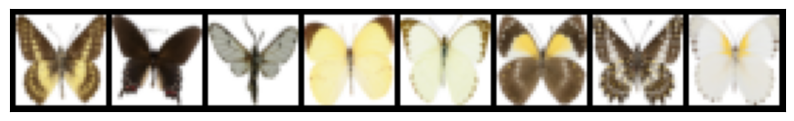

In [10]:
# Load a batch of images from the dataset and display them to verify the data loading and transformation pipeline
batch = next(iter(train_dataloader))
print('Shape:', batch['images'].shape,
      '\nBounds:', batch['images'].min().item(), 'to', batch['images'].max().item())

grid = torchvision.utils.make_grid(batch['images'][:8]*0.5 + 0.5)  # map back to (0, 1) for display
show(grid)

### Noise Schedule and Model Definition

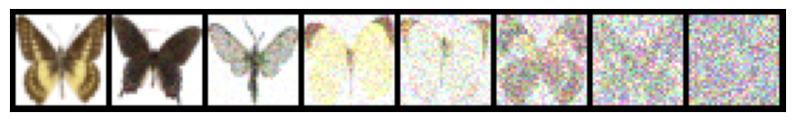

In [11]:
# Define an example noise schedule and demonstrate adding noise to the batch

scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02, beta_schedule="squaredcos_cap_v2")
timesteps = torch.linspace(0, 999, 8).long()

x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

grid = torchvision.utils.make_grid((noised_x*0.5 + 0.5).clip(0, 1))  # cut to [0, 1]
show(grid)

In [12]:
# Create a UNet2DModel for denoising and test it by passing a batch of noised images through the model

# Create a UNet2DModel
model =  diffusers.UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=32,  # Specify our input size
    block_out_channels=(32, 64, 128), # N channels per layer
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
)

# Pass a batch of data through
with torch.no_grad():
    out = model(noised_x, timestep=timesteps).sample
out.shape

torch.Size([8, 3, 32, 32])

### Training

In [13]:
%%time

# Train the UNet2DModel on the dataset using the AdamW optimizer and mean squared error loss

num_epochs = 50  # How many runs through the data should we do?
lr = 2e-4  # What learning rate should we use
model = model.to(device)  # The model we're training (defined in the previous section)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)  # The optimizer
losses = []  # somewhere to store the loss values for later plotting
F = torch.nn.functional

print(f"Using device: {device}")

# Train the model (this takes a while!)
for epoch in range(num_epochs):
    print(f'{epoch} ', end='')
    if epoch%10 == 9:
        print();

    for step, batch in enumerate(train_dataloader):

        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

Using device: mps
0 1 2 3 4 5 6 7 8 9 
10 11 12 13 14 15 16 17 18 19 
20 21 22 23 24 25 26 27 28 29 
30 31 32 33 34 35 36 37 38 39 
40 41 42 43 44 45 46 47 48 49 
CPU times: user 6min 17s, sys: 31 s, total: 6min 48s
Wall time: 6min 35s


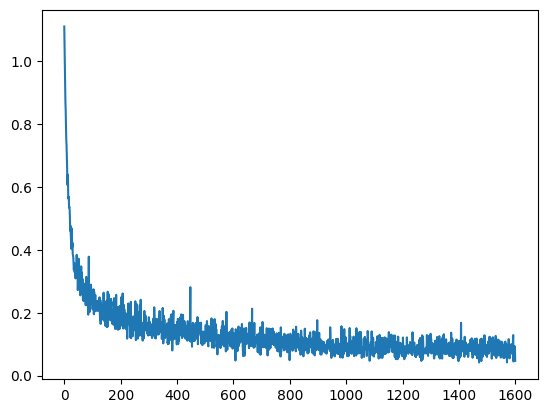

In [14]:
# Plot the training loss over time to visualize the model's convergence
plt.plot(losses)
plt.show()

### Generate Sample Images

  0%|          | 0/1000 [00:00<?, ?it/s]

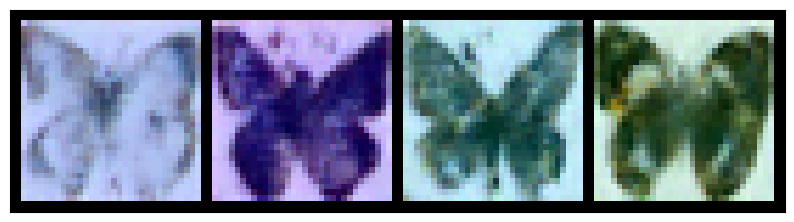

In [15]:
# Create a pipeline to use the trained UNet2DModel to generate denoised images. Display the results.

pipeline = diffusers.DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images

convert_tensor = torchvision.transforms.ToTensor()
tims = [convert_tensor(i) for i in ims]
grid = torchvision.utils.make_grid(tims)  # cut to [0, 1]
show(grid)

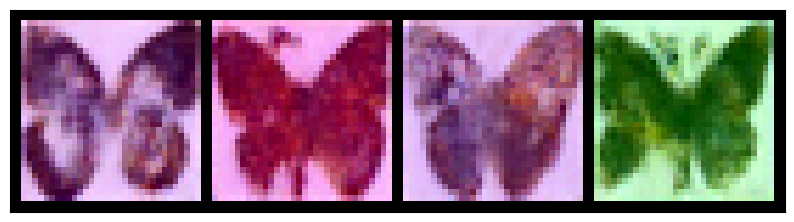

In [16]:
# Generate 4 new images by iteratively refining a random starting point using the trained model and scheduler

# Random starting point (4 random images):
sample = torch.randn(4, 3, 32, 32).to(device)

for i, t in enumerate(scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        noise_pred = model(sample, t).sample

    # Update sample with step
    sample = scheduler.step(noise_pred, t, sample).prev_sample

# Display the generated images based on the random starting points
ims = sample.clip(-1, 1)*0.5 + 0.5
grid = torchvision.utils.make_grid(ims)
show(grid)

## Exercise 1: Simple Scheduler

Implement your own scheduler to add noise

In [17]:
# Corrupt function adds desired amount of noise to an image

def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

In [18]:
# Define a simple scheduler that adds noise linearly

class SimpleScheduler:
    def __init__(self):
        self.num_train_timesteps = 1000

    def add_noise(self, x, noise, timesteps):
        amount = timesteps / self.num_train_timesteps
        return corrupt(x, noise, amount)

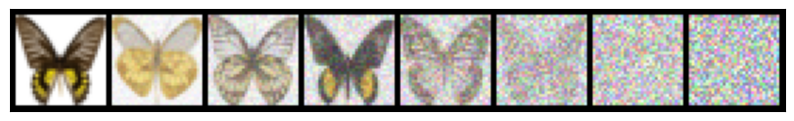

In [19]:
# Use the simple scheduler to add noise and display the noised images

scheduler = SimpleScheduler()
timesteps = torch.linspace(0, 999, 8).long()

x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

grid = torchvision.utils.make_grid((noised_x*0.5 + 0.5).clip(0, 1))  # cut to [0, 1]
show(grid)

Let's compare these results with other schedulers in the diffusers library

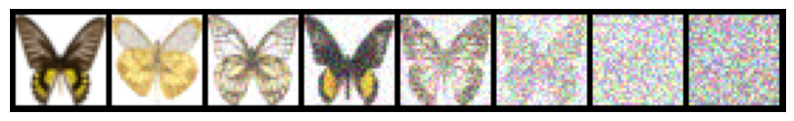

In [20]:
scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02, beta_schedule="squaredcos_cap_v2")
timesteps = torch.linspace(0, 999, 8).long()

x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

grid = torchvision.utils.make_grid((noised_x*0.5 + 0.5).clip(0, 1))  # cut to [0, 1]
show(grid)

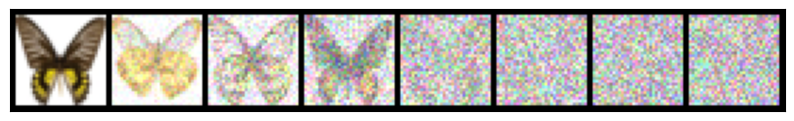

In [21]:
scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02, beta_schedule="linear")
timesteps = torch.linspace(0, 999, 8).long()

x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

grid = torchvision.utils.make_grid((noised_x*0.5 + 0.5).clip(0, 1))  # cut to [0, 1]
show(grid)

### What do you notice? How could varying the scheduler impact the model's results?

Varying the scheduler could significantly impact the model's results. For example:

* Changing the beta schedule to a non-linear schedule, such as a quadratic or logarithmic schedule, could affect the rate at which the noise is added or removed during the diffusion process.
* Adjusting the beta_start and beta_end values could control the overall noise level and the range of noise values used during the diffusion process.
* Increasing or decreasing the num_steps value could affect the granularity of the noise schedule and the overall quality of the generated images.

## Exercise 2: Nonlinear Schedulers

### Quadratic Scheduler

This scheduler uses a quadratic schedule to control the amount of noise added to the input. The amount of noise added increases rapidly at the beginning and then slows down as the timesteps progress.

With a quadratic scheduler, less noise is added early in the diffusion process, and more noise is added later. This means that the denoising process would start by removing a lot of noise in the early stages, and then refine the resolution at the end.

As a result, the generated images may improve details at the cost of diversity:
* Higher Quality: Early noise removal results in more iterations spent on denoising refined details, leading to more precise, realistic features and a higher quality image.
* Less Variance: Removing most of the noise early means less iterations are spent denoising macroscopic features, which can limit the variance in shape, color, and texture.

In [22]:
class QuadraticScheduler:
    def __init__(self, num_train_timesteps):
        self.num_train_timesteps = num_train_timesteps

    def add_noise(self, x, noise, timesteps):
        amount = (timesteps / self.num_train_timesteps) ** 2
        return corrupt(x, noise, amount)

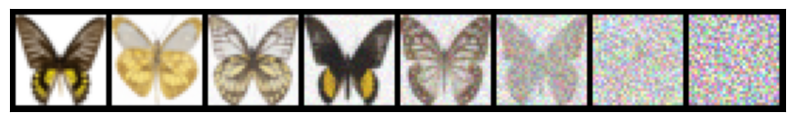

In [23]:
scheduler = QuadraticScheduler(num_train_timesteps=1000)
timesteps = torch.linspace(0, 999, 8).long()

x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

grid = torchvision.utils.make_grid((noised_x*0.5 + 0.5).clip(0, 1))  # cut to [0, 1]
show(grid)

### Logarithmic Scheduler

This scheduler uses a logarithmic schedule to control the amount of noise added to the input. The amount of noise added increases slowly at the beginning and then rapidly as the timesteps progress.

With a logarithmic scheduler, more noise is added early in the diffusion process, and less noise is added later. This means that the denoising process would start by removing very little noise in the early stages, and much more noise in the later stages.

As a result, the generated images may improve diversity at the cost of details:
* Higher Variance: Removing less noise early on means more iterations are spent denoising macroscopic features, which allows the model to explore a broader range of shapes, colors, and textures in the early stages.
* Lower Quality: More noise is removed later in the process, which results in less iterations spent on denoising refined details. This can lead to less precise features and a lower quality image. 

In [33]:
class RootScheduler:
    def __init__(self, num_train_timesteps):
        self.num_train_timesteps = num_train_timesteps

    def add_noise(self, x, noise, timesteps):
        amount = (timesteps / self.num_train_timesteps)**0.5
        return corrupt(x, noise, amount)

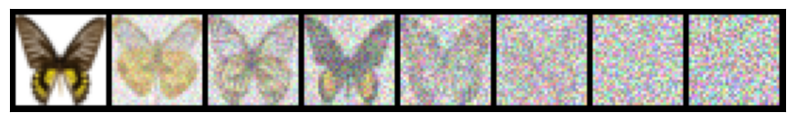

In [34]:
scheduler = RootScheduler(num_train_timesteps=1000)
timesteps = torch.linspace(0, 999, 8).long()

x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

grid = torchvision.utils.make_grid((noised_x*0.5 + 0.5).clip(0, 1))  # cut to [0, 1]
show(grid)